In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time

from IPython import display

## Load and Prepare data
In this piece of code, we imported data and reshaped it. Images are represented in the values between 0 to 255. So these image vectors are converted into values between [-1, 1]. Then these vectors are shuffled and converted to batches of 256 images.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
next(iter(train_dataset)).shape

TensorShape([256, 28, 28, 1])

## Create Models

### generator
The generator model will take vector of 100 pixels as input and convert that vector into an image of 28 * 28 using the Conv2DTranspose layer. As we are using convolutions, this model will be a DCGAN i.e. Deep Convolutional Generative Adversarial Network.

In [ ]:
def create_generator():
    model = tf.keras.Sequential()
    
    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

### Discriminator
Discriminator will do the exact opposite of a generator and convert image into scalar probabilities of whether the image is fake or real. It will use the Conv2D layer for this purpose. Along with the convolutional layer, it will have layer of an activation function “LeakyReLU” and the Dropout layer.

In [ ]:
def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Define Loss and Optimizers
Here, we’re using BinaryCrossentropy from tf.keras.losses API. Using this cross_entropy loss, we’ll make loss functions for discriminator and generator.

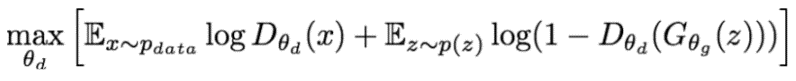

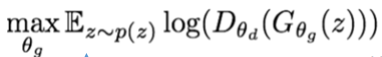

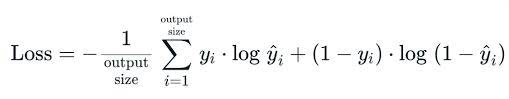

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Now, we’ll create optimizers for generator and discriminator using Adam optimizer from tf.keras.optimizers API with a learning rate of 1e-4.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define Training functions
Initially, the generator will generate an image with only random pixels and as time passes, it will make images that are almost similar to the training images. Image from the generator before training looks like the following:

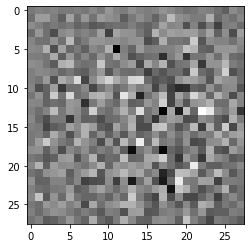

In [ ]:
generator = create_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

First, we need to create noise data for passing into the generator model. Then create a function to learn through iterations using the concept of Eager Execution.

In [ ]:
noise_dim = 100

discriminator = create_discriminator()

@tf.function
def train_step(images):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = G_loss(fake_output)
      disc_loss = D_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

GradientTape above is used for creating gradients as we go further and these gradients are applied to optimizers for decreasing the loss function.

In [ ]:
def train_GAN(dataset, epochs):
  result = {'gen_loss':[], 'disc_loss':[]}
  for epoch in range(epochs):
    start = time.time()

    b_counter = 0
    gen_loss = 0
    disc_loss = 0
    for image_batch in dataset:
      b_counter += 1
      gl, dl = train_step(image_batch)
      gen_loss += gl
      disc_loss += dl
    result['gen_loss'].append(gen_loss/b_counter)
    result['disc_loss'].append(disc_loss/b_counter)
    print ('Time for epoch {} is {} sec, generator loss: {}, discriminator loss: {}'.format(epoch + 1, time.time()-start, gen_loss/b_counter, disc_loss/b_counter))
  
  return result

This is the final function to call the train_step function for each batch in the dataset.

Finally, we’ll call our train_GAN function to start training on the image dataset with 100 epochs.

In [ ]:
result = train_GAN(train_dataset, 100)

Time for epoch 1 is 10.323070287704468 sec, generator loss: 1.2705621719360352, discriminator loss: 0.9874528646469116
Time for epoch 2 is 6.130089044570923 sec, generator loss: 1.5822216272354126, discriminator loss: 0.8218093514442444
Time for epoch 3 is 6.122906684875488 sec, generator loss: 1.3386404514312744, discriminator loss: 0.918620228767395
Time for epoch 4 is 6.144352674484253 sec, generator loss: 1.4435148239135742, discriminator loss: 0.9131612777709961
Time for epoch 5 is 6.1775312423706055 sec, generator loss: 1.4283998012542725, discriminator loss: 0.9701306819915771
Time for epoch 6 is 6.110320091247559 sec, generator loss: 1.1841164827346802, discriminator loss: 1.1320431232452393
Time for epoch 7 is 6.13232684135437 sec, generator loss: 1.2090413570404053, discriminator loss: 1.0123478174209595
Time for epoch 8 is 6.294869422912598 sec, generator loss: 1.297754168510437, discriminator loss: 1.076196312904358
Time for epoch 9 is 6.2056989669799805 sec, generator loss

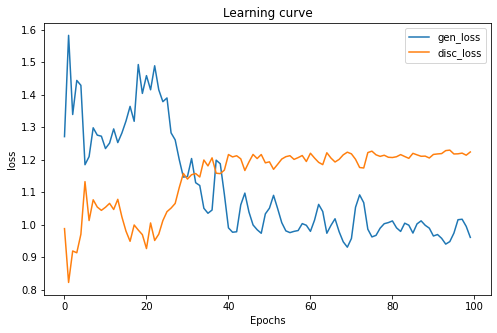

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.title("Learning curve")
plt.plot(result["gen_loss"], label="gen_loss")
plt.plot(result["disc_loss"], label="disc_loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

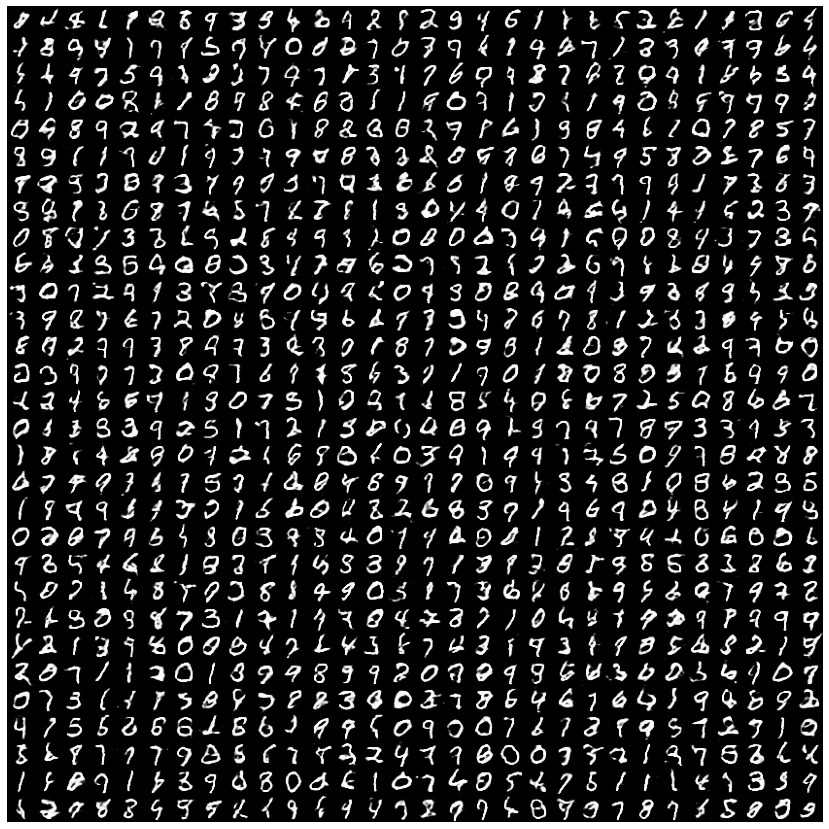

In [ ]:
def plot_latent_space(gen, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = tf.random.normal([1, 100])
            x_decoded = gen.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.axis('off')
    plt.show()


plot_latent_space(generator)

# Contact me!!
If you have questions, please feel free to ask. \\
`RezaKarimzadeh1996@gmail.com`